QATAR MISSION NEWS ARTICLES

https://ny.mission.qa/en/media/news

In [ ]:
pip install requests beautifulsoup4

Step 1 - Scrape all Mission News Articles within the Past 2 Years

In [3]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pandas as pd

In [4]:

# --- CONFIGURATION ---
BASE_URL = "https://ny.mission.qa"
START_PAGE = "/en/media/news"
CUTOFF_DATE = datetime.now() - timedelta(days=2 * 365)  # 2 years ago

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
        "(KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    )
}

# --- FUNCTIONS ---
def get_soup(url, retries=5, delay=5):
    for attempt in range(1, retries + 1):
        try:
            print(f"→ Requesting page (attempt {attempt}): {url}")
            res = requests.get(url, headers=HEADERS, timeout=30)
            res.raise_for_status()
            return BeautifulSoup(res.text, "html.parser")
        except requests.exceptions.Timeout:
            print(f"⏳ Timeout on attempt {attempt} for {url}")
            time.sleep(delay * attempt)  # exponential backoff
        except requests.exceptions.HTTPError as e:
            print(f"❌ HTTP error on {url}: {e}")
            raise
        except Exception as e:
            print(f"❌ Unexpected error: {e}")
            raise
    raise Exception(f"Failed to load page after {retries} retries: {url}")

def parse_listing(soup):
    articles = []
    for article in soup.select("div.news-list article"):
        link_tag = article.select_one("a[href]")
        title_tag = article.select_one("h2.news-header")
        date_tag = article.select_one("time.gray-light")

        if not (link_tag and title_tag and date_tag):
            continue

        url = link_tag["href"]
        title = title_tag.text.strip()
        date_str = date_tag.text.strip()

        try:
            pub_date = datetime.strptime(date_str, "%d %B %Y")
        except ValueError:
            continue

        articles.append({
            "title": title,
            "url": url if url.startswith("http") else BASE_URL + url,
            "pub_date": pub_date.strftime("%Y-%m-%d")
        })
    return articles

def get_next_page_url(soup):
    next_btn = soup.select_one("ul.pager li a:contains('Next')")
    if next_btn:
        return BASE_URL + next_btn['href']
    return None

def get_article_body(url):
    try:
        soup = get_soup(url)
        content_block = soup.find("h3", class_="normal margin-bottom-70")

        if not content_block:
            return ""

        # Case A: contains <p> tags
        p_tags = content_block.find_all("p")
        if p_tags:
            article_text = "\n".join(p.get_text(strip=True) for p in p_tags)
        else:
            # Case B: treat inner HTML as lines, split by <br>
            raw_html = str(content_block)
            soup_inner = BeautifulSoup(raw_html, "html.parser")
            article_text = soup_inner.get_text(separator="\n").strip()

        return article_text

    except Exception as e:
        print(f"⚠️ Failed to get article body for {url}: {e}")
        return ""


In [ ]:
page_url = BASE_URL + START_PAGE
all_articles = []

while page_url:
    print(f"\n🌍 Scraping: {page_url}")
    try:
        soup = get_soup(page_url)
    except Exception as e:
        print(f"🚨 Stopping due to repeated failure: {e}")
        break

    articles = parse_listing(soup)
    if not articles:
        print("⚠️ No articles found on this page.")
        break

    if all(datetime.strptime(a["pub_date"], "%Y-%m-%d") < CUTOFF_DATE for a in articles):
        print("📉 All articles are older than 2 years. Stopping.")
        break

    for article in articles:
        pub_date = datetime.strptime(article["pub_date"], "%Y-%m-%d")
        if pub_date >= CUTOFF_DATE:
            full_url = article["url"]
            print(f"✔ {article['pub_date']} | {article['title']}")
            article_text = get_article_body(full_url)
            article["content"] = article_text
            all_articles.append(article)
            time.sleep(1)

    next_page_link = soup.select_one("ul.pager li:has(a:contains('Next')) a")
    if next_page_link:
        page_url = BASE_URL + next_page_link['href']
        time.sleep(2)  # polite delay between pages
    else:
        print("✅ Reached the last page.")
        break

excel_path = "qatar_mission_articles.xlsx"
sheet_name = 'raw'

print(f"\n✅ Total articles collected: {len(all_articles)}")
if all_articles:
    df = pd.DataFrame(all_articles)
    df.to_excel(excel_path, sheet_name=sheet_name, index=False)
    print(f"📄 Articles saved to {excel_path}")


🌍 Scraping: https://ny.mission.qa/en/media/news
→ Requesting page (attempt 1): https://ny.mission.qa/en/media/news
✔ 2025-06-24 | Qatar Affirms Continued Support for Afghan People in Facing Multiple Challenges, Assisting Them to Achieving Peace and Stability
→ Requesting page (attempt 1): https://ny.mission.qa/en/media/news/detail/1446/12/28/qatar-affirms-continued-support-for-afghan-people-in-facing-multiple-challenges-assisting-them-to-achieving-peace-and-stability
✔ 2025-06-24 | State of Qatar Sends Letter to UN Secretary-General, Security Council Regarding Attack on Al-Udeid Air Base by Iranian Revolutionary Guard
→ Requesting page (attempt 1): https://ny.mission.qa/en/media/news/detail/1446/12/28/state-of-qatar-sends-letter-to-un-secretary-general-security-council-regarding-attack-on-al-udeid-air-base-by-iranian-revolutionary-guard
✔ 2025-06-20 | Qatar Affirms it Continued Efforts to Support Dealing with Root Causes of Poverty
→ Requesting page (attempt 1): https://ny.mission.qa/

c:\Users\spy06\miniconda3\envs\gensim-env\Lib\site-packages\soupsieve\css_parser.py:876: FutureWarning: The pseudo class ':contains' is deprecated, ':-soup-contains' should be used moving forward.
  warnings.warn(  # noqa: B028



🌍 Scraping: https://ny.mission.qa/en/media/news/page/2
→ Requesting page (attempt 1): https://ny.mission.qa/en/media/news/page/2
⏳ Timeout on attempt 1 for https://ny.mission.qa/en/media/news/page/2
→ Requesting page (attempt 2): https://ny.mission.qa/en/media/news/page/2
⏳ Timeout on attempt 2 for https://ny.mission.qa/en/media/news/page/2
→ Requesting page (attempt 3): https://ny.mission.qa/en/media/news/page/2
✔ 2025-05-30 | Qatar Participates in Preparatory Meeting of High-Level International Conference for Peaceful Settlement of Question of Palestine and Implementation of Two-State Solution
→ Requesting page (attempt 1): https://ny.mission.qa/en/media/news/detail/1446/12/06/qatar-participates-in-preparatory-meeting-of-high-level-international-conference-for-peaceful-settlement-of-question-of-palestine-and-implementation-of-two-state-solution
✔ 2025-05-30 | Permanent Representative of Qatar to UN Meets Under-Secretary-General of UN Counter-Terrorism Office
→ Requesting page (attem

Step 2 - Data Analysis

Theme Identification

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud
import numpy as np
import csv
import matplotlib.pyplot as plt
import re

# Custom stopwords
custom_stopwords = set([
    'project', 'include', 'support', 'activities', 'expected', 'providing', 'humanitarian', 'assistance',
    'contributing', 'including', 'increased', 'cfli', 'outcomes', 'projects', 'needs', 'improved',
    'populations', 'people', 'organizations', 'countries', 'affected', 'small', 'international', 'local',
    'human', 'services', 'vulnerable', 'dignity', 'canada', 'aims', 'development', 'persons', 'access',
    'global', 'economic', 'national', 'canadian', 'implementation', 'states', 'capacity', 'acute',
    'outcome', 'million', 'developing', 'action', 'fund', 'united', 'nations', 'funding', '19', 'womenâ',
    'regional', 'priorities', 'red', 'initiatives', 'direct', 'advance', 'strengthen', 'situations',
    'community', 'communities', 'coordination', 'inclusive', 'policy', 'based', 'technical', 'lives',
    'strengthened', 'themes', 'offer', 'focusing', 'provide', 'closely', 'implemented', 'saved', 'ultimate',
    'suffering', 'alleviated', 'maintained', 'experiencing', 'excellency', 'meeting', 'met', 'qna', 'efforts',
    'new', 'york', 'qatar', 'qatars', 'challenges', 'event', 'role', 'highlighted', 'althani', 'alya',
    'ahmed', 'bin', 'cooperation', 'state', 'sheikha', 'saif', 'discussed', 'doha', 'general', 'headquarters',
    'permanent', 'mission', 'republic', 'affairs', 'representative', 'president', 'east', 'world', 'assembly',
    'noted', 'added', 'said', 'thani', 'secretary', 'under', 'al'
])

texts = df['content']

# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

Theme Identification via Natural Language Processing (NLP)

In [5]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['terrorism', 'counter', 'security']
Topic 1:
['gaza', 'palestinian', 'strip']
Topic 2:
['education', 'social', 'women']
Topic 3:
['peace', 'security', 'conflicts']
Topic 4:
['children', 'conflict', 'afghanistan']


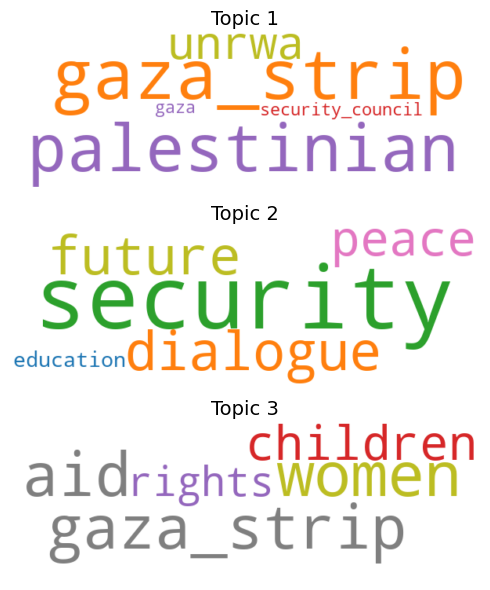

In [6]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [7]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    wc.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to Topic_WordCloud in qatar_mission_articles.xlsx


Identifying Themes Via Keyword Frequency

In [8]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    000  02  07  10th  13  16  17  18  1967  2020  ...  work  working  works  \
0    0   0   0     0   0   0   0   0     0     1  ...     0        3      0   
1    0   0   0     0   0   0   0   0     0     0  ...     0        0      0   
2    0   0   0     0   0   0   0   0     0     0  ...     0        0      0   
3    0   0   0     0   0   0   0   0     0     0  ...     0        0      1   
4    0   0   0     0   0   0   0   0     0     0  ...     0        0      0   

   worldwide  worsening  wounded  year  years  youth  zones  
0          0          0        0     0      0      1      0  
1          0          0        0     0      0      0      0  
2          0          0        0     0      0      0      0  
3          0          0        0     0      0      0      0  
4          0          0        0     0      0      0      0  

[5 rows x 809 columns]


In [9]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
security       210
gaza           201
palestinian    170
peace          169
strip          138
council        129
israeli         99
law             91
aid             90
sustainable     82
civilians       80
arab            77
children        77
resolution      76
stressed        75
women           71
conflict        71
education       68
terrorism       67
region          66
dtype: int64


In [10]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
gaza           7.304640
security       6.170179
palestinian    5.853086
strip          5.660357
peace          5.576229
special        4.830273
children       4.501937
aid            4.063405
terrorism      4.026712
conflict       3.956546
dtype: float64


AI Tagging

In [8]:
excel_path = "qatar_mission_articles.xlsx"

In [12]:
tagged = pd.read_excel(excel_path, sheet_name="raw")

tagged.head()

,title,url,pub_date,content,theme_1,theme_2
0,Qatar Affirms Continued Support for Afghan Peo...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-24,The State of Qatar reaffirmed its continued su...,Afghanistan Peace Process,Humanitarian Aid
1,State of Qatar Sends Letter to UN Secretary-Ge...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-24,The State of Qatar sent a letter to HE Secreta...,Peacebuilding and Mediation,UN and Multilateral Diplomacy
2,Qatar Affirms it Continued Efforts to Support ...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-20,The State of Qatar reaffirmed its continued co...,Economic Development,Humanitarian Aid
3,Qatar Calls for Real Measures to Support Peace...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-19,The State of Qatar called for taking real meas...,Palestinian Conflict,Peacebuilding and Mediation
4,Qatar's Permanent Representative to UN Meets P...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-19,HE Permanent Representative of the State of Qa...,UN and Multilateral Diplomacy,Technology and Innovation


In [13]:
tagged = tagged.melt(
    id_vars = [col for col in tagged.columns if col not in ['theme_1', 'theme_2']],
    value_vars = ['theme_1', 'theme_2'],
    var_name = 'theme_source',
    value_name = 'theme'
)

tagged = tagged.drop(columns=['theme_source'])

tagged['pub_date'] = pd.to_datetime(tagged['pub_date'], errors='coerce')
tagged['year'] = tagged['pub_date'].dt.year

tagged.head()

,title,url,pub_date,content,theme,year
0,Qatar Affirms Continued Support for Afghan Peo...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-24,The State of Qatar reaffirmed its continued su...,Afghanistan Peace Process,2025
1,State of Qatar Sends Letter to UN Secretary-Ge...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-24,The State of Qatar sent a letter to HE Secreta...,Peacebuilding and Mediation,2025
2,Qatar Affirms it Continued Efforts to Support ...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-20,The State of Qatar reaffirmed its continued co...,Economic Development,2025
3,Qatar Calls for Real Measures to Support Peace...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-19,The State of Qatar called for taking real meas...,Palestinian Conflict,2025
4,Qatar's Permanent Representative to UN Meets P...,https://ny.mission.qa/en/media/news/detail/144...,2025-06-19,HE Permanent Representative of the State of Qa...,UN and Multilateral Diplomacy,2025


In [14]:
sheet_name = "tagging"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    tagged.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to tagging in qatar_mission_articles.xlsx
